## Prep Work

* Author: [leip@](https://moma.corp.google.com/person/leip)
* Date: 10/03/23

In [ ]:
import sys

if 'google.colab' in sys.modules:
    ! pip install google-cloud-aiplatform
    ! pip install google-cloud-discoveryengine
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

In [ ]:
import vertexai
from vertexai.preview.language_models import CodeGenerationModel, TuningEvaluationSpec

VERTEX_API_PROJECT = 'cloud-llm-preview4'
VERTEX_API_LOCATION = 'us-central1'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)

## Fine tune codey model to understand custom codebase security issues

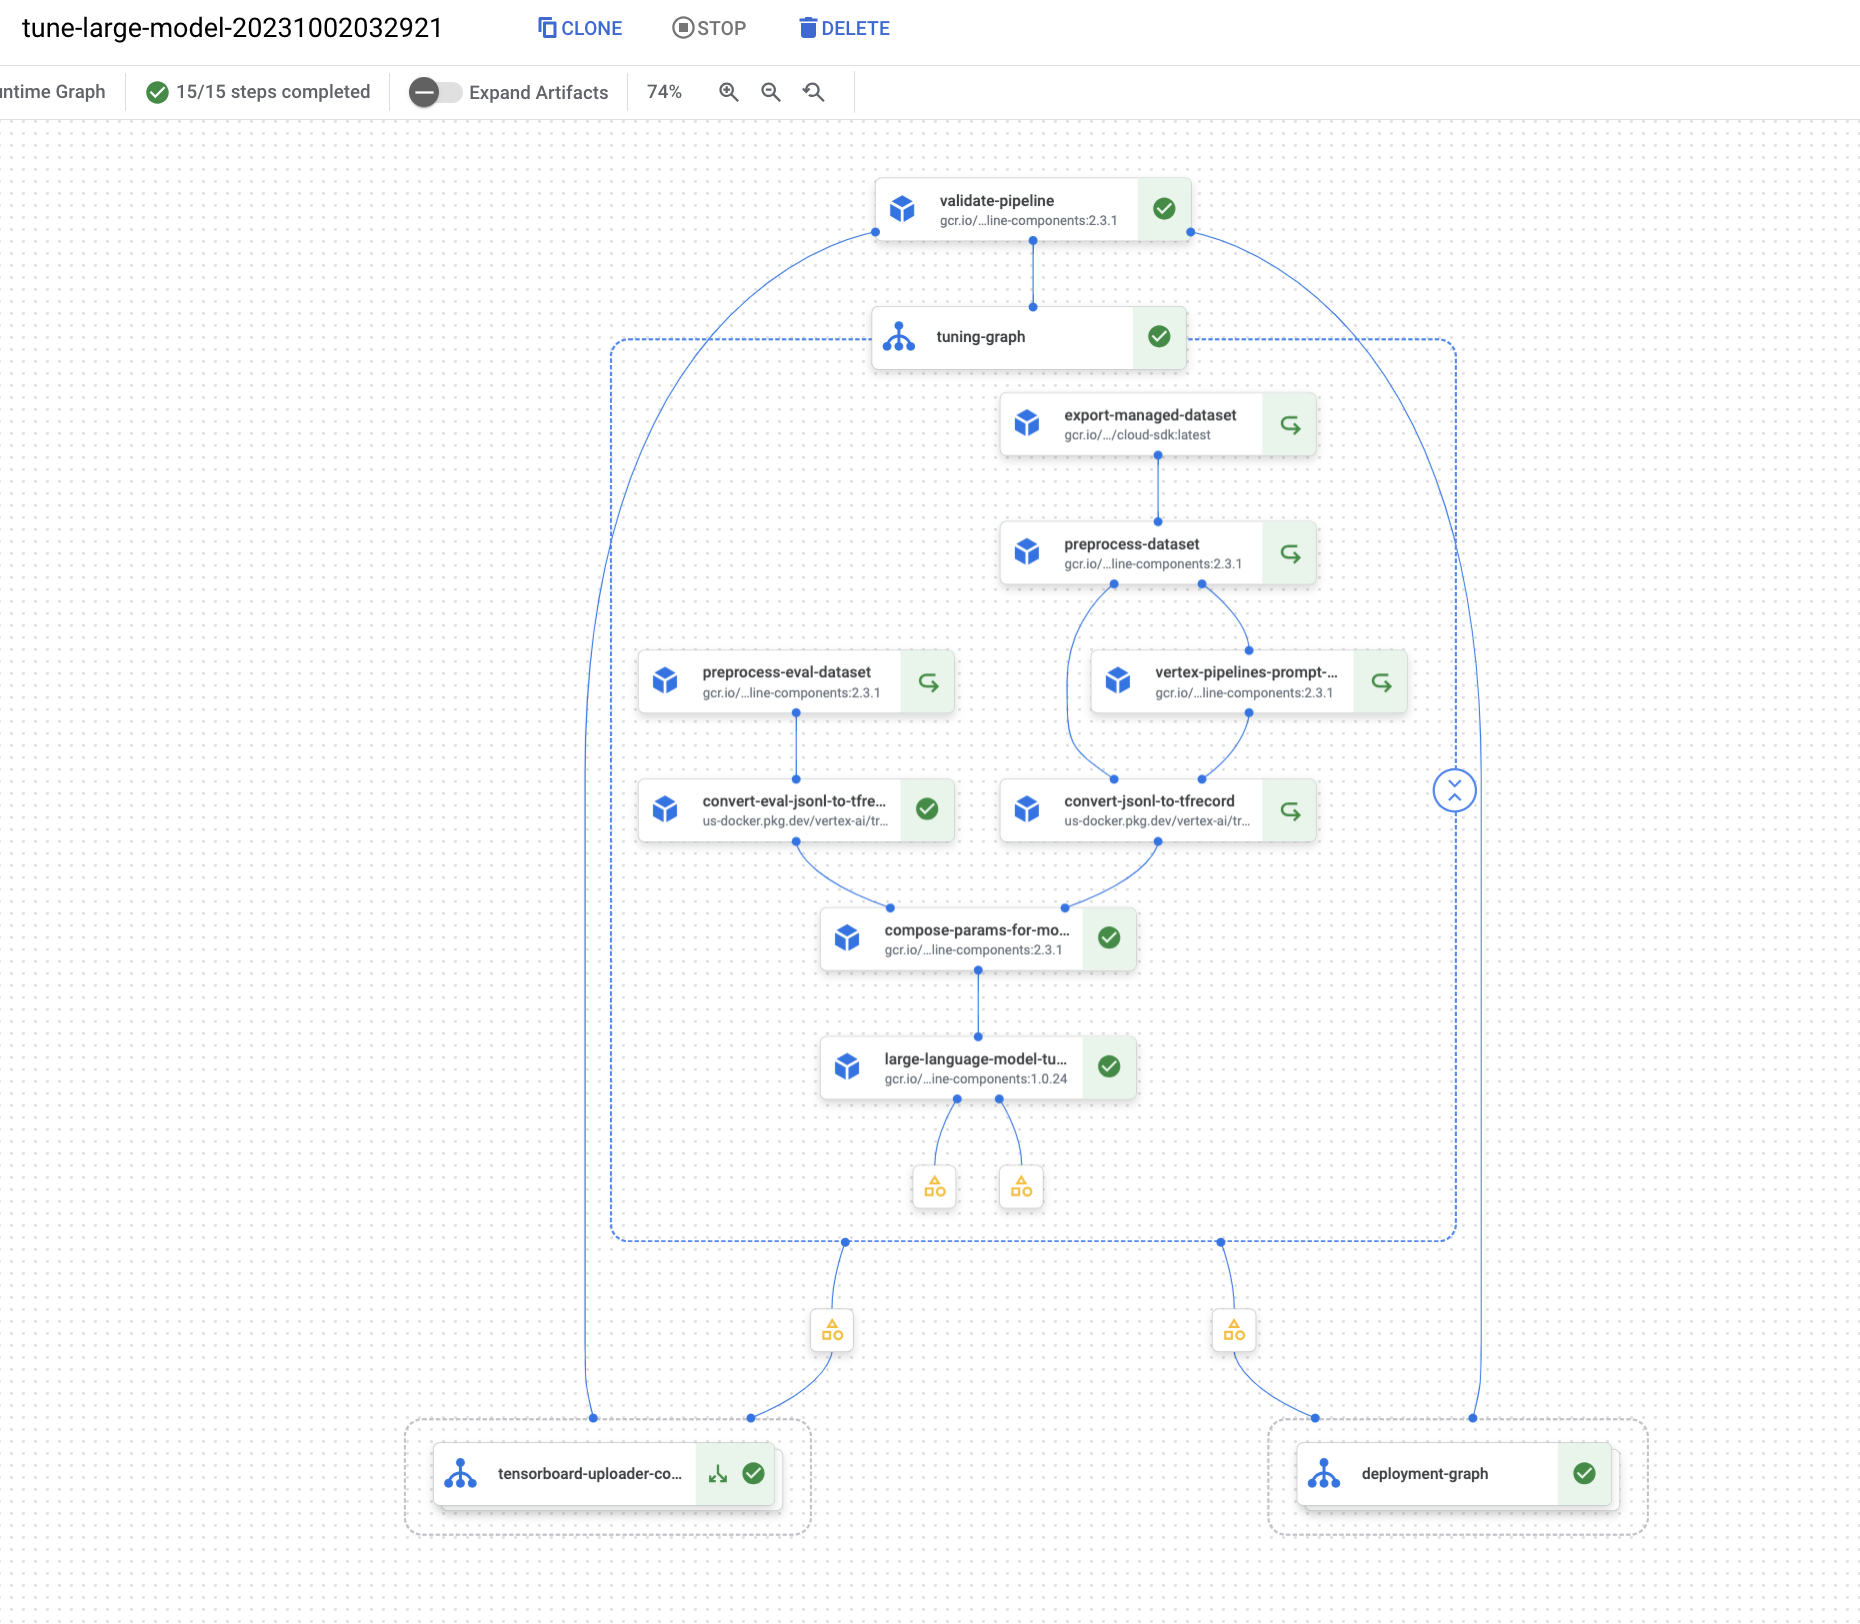

In [ ]:
model = CodeGenerationModel.from_pretrained("code-bison@001")

eval_dataset_url = TuningEvaluationSpec("gs://codey-fine-tuning/eval_dataset/codeydataset_eval.jsonl")
training_dataset_url = "gs://codey-fine-tuning/training_dataset/codeydataset.jsonl"
model.tune_model(
    training_data=training_dataset_url,
    train_steps=200,
    tuning_job_location="europe-west4",
    tuned_model_location="us-central1",
    model_display_name="codey-custom-model",
    tuning_evaluation_spec=eval_dataset_url
)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20231003220458


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20231003220458


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20231003220458')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/308351622118/locations/europe-west4/pipelineJobs/tune-large-model-20231003220458')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/tune-large-model-20231003220458?project=308351622118


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/tune-large-model-20231003220458?project=308351622118


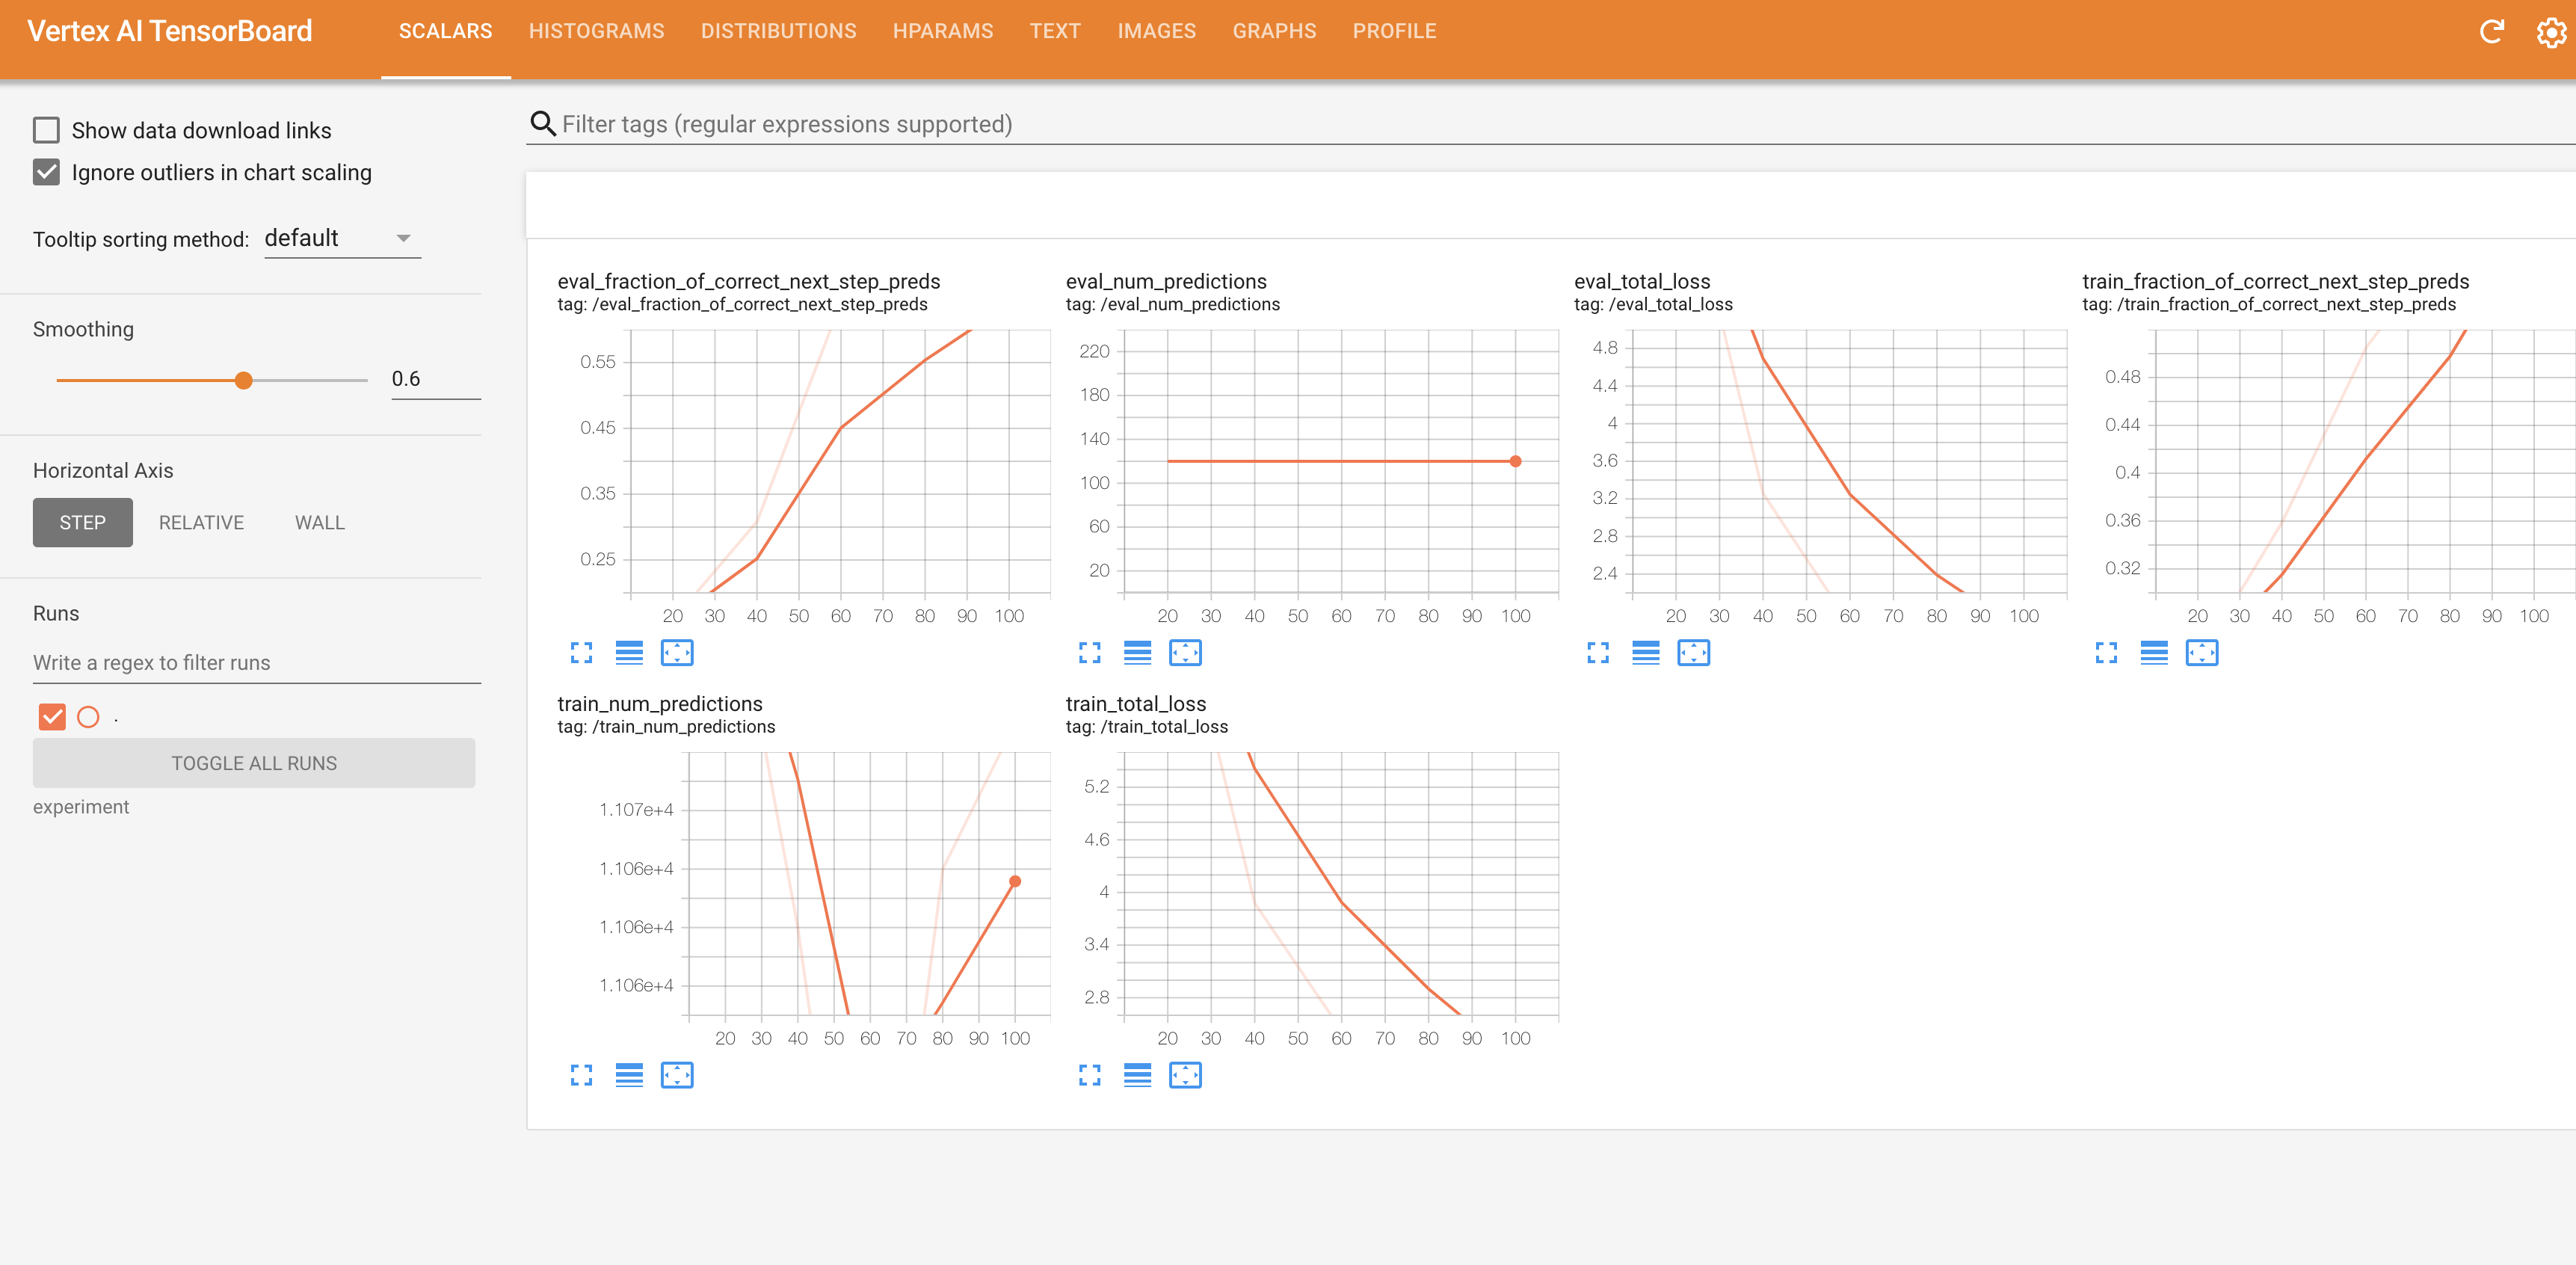

## List all the fine tuned codey models

In [ ]:
list_models = CodeGenerationModel.from_pretrained("code-bison@001").list_tuned_model_names()
list_models

['projects/308351622118/locations/us-central1/models/2650674044940058624',
 'projects/308351622118/locations/us-central1/models/6700716329759932416']

## Load the fine tuned codey model

In [ ]:
TUNED_MODEL_NAME = list_models[0]

In [ ]:
model = CodeGenerationModel.get_tuned_model(TUNED_MODEL_NAME)

## Use the fine tuned codey model to identify security issues in the custom codebase

In [ ]:
def fine_tuned_model_predict(model, prefix):
  parameters = {
    "temperature": 0,
    "max_output_tokens": 2048
  }
  return model.predict(
    prefix=prefix, **parameters
  ).text

In [ ]:
prefix_1 = """You are great at observing code vulnerabilities. Please explain to me if the code block below has any code vulnerabilities. If not, just say no issues. If yes, explain what vulnerabilities it has.
public static void listFiles(String dir) throws Exception
  {
  Runtime rt = Runtime.getRuntime();
  Process proc = rt.exec(new String[] {"sh", "-c", "ls " + dir});
  int result = proc.waitFor();
  if (result != 0) {
    System.out.println("process error: " + result);
    }
    InputStream in = (result == 0) ? proc.getInputStream() :
    proc.getErrorStream();
    int c;
    while ((c = in.read()) != -1) {
    System.out.print((char) c);
  }
}

"""

In [ ]:
prefix_2 = """You are great at observing code vulnerabilities. Please explain to me if the code block below has any code vulnerabilities. If not, just say no issues. If yes, explain what vulnerabilities it has.

String path = "C:\\Windows\\system32\\cmd.exe";
ProcessBuilder pb = new ProcessBuilder(path);
pb.command().add("/c");
pb.command().add("ping.exe");
pb.command().add(userInput);
Process pingProcess = pb.start();
"""

In [ ]:
prefix_3 = """
You are great at observing code vulnerabilities. Please explain to me if the code block below has any code vulnerabilities. If not, just say no issues. If yes, explain what vulnerabilities it has. \n```\nString query = \"SELECT * FROM Users WHERE UserId = 105 OR 1=1;\";\nConnection conn = db.getConn();\nStatement stmt = conn.createStatement();\n\n\nResultSet rs = stmt.executeQuery(query);\n```
"""

In [ ]:
print(fine_tuned_model_predict(model, prefix_1))

The code block has the following vulnerabilities:

* **SQL injection vulnerability**. The query string is not properly sanitized, which could allow an attacker to inject malicious SQL code into the database. This could lead to a variety of security issues, such as data theft, denial of service attacks, and more.
* **Code injection vulnerability**. The code block uses a hard-coded password to connect to the database. This is a security risk because if the password is leaked, an attacker could use it to access the database.
* **Insecure direct object reference vulnerability**. The query string includes the user ID 105. This could be a security risk if the user ID is not properly validated. For example, if an attacker is able to guess the user ID of a privileged user, they could use this query to access that user's data.

To fix these vulnerabilities, you can take the following steps:

* **Sanitize the query string**. To prevent SQL injection attacks, you should use a prepared statement o

In [ ]:
print(fine_tuned_model_predict(model, prefix_2))

The code block has the following vulnerabilities:

* **Command injection vulnerability:** The user input is directly passed to the `ping.exe` command, which could allow an attacker to execute arbitrary commands on the system.
* **Code injection vulnerability:** The code block uses the `/c` switch to execute a command in the command prompt. This could allow an attacker to inject malicious code into the command and execute it on the system.
* **Path traversal vulnerability:** The code block uses the `C:\Windows\system32\cmd.exe` path to execute the `ping.exe` command. This could allow an attacker to access files outside of the specified path.

To fix these vulnerabilities, you can use the following steps:

1. **Use the `ProcessBuilder.command()` method to specify the commands to execute.** This will prevent the user input from being directly passed to the `ping.exe` command.
2. **Use the `ProcessBuilder.directory()` method to specify the working directory.** This will prevent the attacke

In [ ]:
print(fine_tuned_model_predict(model, prefix_3))

The code block has the following vulnerabilities:

* **SQL injection vulnerability**. The query string is not properly sanitized, which could allow an attacker to inject malicious SQL code into the database. This could lead to a variety of security issues, such as data theft, denial of service attacks, and more.
* **Code injection vulnerability**. The code block uses a hard-coded password to connect to the database. This is a security risk because if the password is leaked, an attacker could use it to access the database.
* **Insecure direct object reference vulnerability**. The query string includes the user ID 105. This could be a security risk if the user ID is not properly validated. For example, if an attacker is able to guess the user ID of a privileged user, they could use this query to access that user's data.

To fix these vulnerabilities, you can take the following steps:

* **Sanitize the query string**. To prevent SQL injection attacks, you should use a prepared statement o